In [208]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
import mnist
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from IPython.display import clear_output

In [76]:
def GetFlattenImages(file):
    raw = mnist.download_and_parse_mnist_file(file)
    lst = []
    for i in range(raw.shape[0]):
        lst.append(raw[i].flatten())
    return np.array(lst)

def GetAppropriate(*args, rand_state=1337):
    X_tmp = all_mages[labels == args[0]]
    y_tmp = labels[labels == args[0]]
    X_tmp_tst = all_mages_test[labels_test == args[0]]
    y_tmp_tst = labels_test[labels_test == args[0]]
    for digit in args[1:]:
        X_tmp = np.vstack((X_tmp, all_mages[labels == digit]))
        y_tmp = np.hstack((y_tmp, labels[labels == digit]))
        X_tmp_tst = np.vstack((X_tmp_tst, all_mages_test[labels_test == digit]))
        y_tmp_tst = np.hstack((y_tmp_tst, labels_test[labels_test == digit]))
    X_tmp, y_tmp = shuffle(X_tmp, y_tmp, random_state=rand_state)
    X_tmp_tst, y_tmp_tst = shuffle(X_tmp_tst, y_tmp_tst, random_state=rand_state)
    return X_tmp, y_tmp, X_tmp_tst, y_tmp_tst

In [77]:
all_mages = GetFlattenImages('train-images-idx3-ubyte.gz')
labels = mnist.download_and_parse_mnist_file('train-labels-idx1-ubyte.gz')
all_mages_test = GetFlattenImages('t10k-images-idx3-ubyte.gz')
labels_test = mnist.download_and_parse_mnist_file('t10k-labels-idx1-ubyte.gz')

In [192]:
X_train, y_train, X_test, y_test = GetAppropriate(0, 1)
X_train = torch.as_tensor(X_train, dtype=torch.float32) / 256
y_train = torch.as_tensor(y_train, dtype=torch.float32)
X_test = torch.as_tensor(X_test, dtype=torch.float32) / 256
y_test = torch.as_tensor(y_test, dtype=torch.float32)

In [199]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 1))
model.add_module('l2', nn.Sigmoid())

opt = torch.optim.Adam(model.parameters(), lr=0.0001)

def GetLoss(X_batch, y_batch):
    logits = model(X_batch)[:, 0]
    return -torch.mean(y_batch * torch.log(logits) + (1 - y_batch) * torch.log(1 - logits))

def GetBatches(X, y, sz=100):
    permut = np.random.permutation(np.arange(len(X)))
    for i in range(0, X.shape[0] - sz, sz):
        yield X[permut[i:i + sz]], y[permut[i:i + sz]]

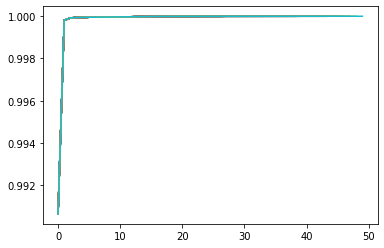

In [200]:
history = []
epochs = 50
batches_sz = 200

for i in range(epochs):
    for X_batch, y_batch in GetBatches(X_train, y_train, batches_sz):
        loss = GetLoss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
    y_pred = model(X_test)
    history.append(roc_auc_score(y_test.data.numpy(), y_pred.data.numpy()))
    clear_output(True)
    plt.plot(list(range(i + 1)), history)

In [211]:
y_pred = model(X_test).data.numpy()
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
accuracy_score(y_test.data.numpy(), y_pred)

0.9995271867612293

In [212]:
model = nn.LogSoftmax()
arr = torch.randn(3, 5)

In [214]:
model(arr)

/var/folders/hp/2jz8x59n2nq11qf5tn5_l2n00000gn/T/ipykernel_2029/579068833.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  model(arr)


tensor([[-4.8171, -0.4859, -3.1355, -3.2704, -1.2199],
        [-3.6430, -0.8304, -1.0384, -2.3373, -2.4382],
        [-2.0066, -0.9330, -1.5199, -1.7975, -2.4331]])